In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'indian-currency-notes-classifier:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F757568%2F1308548%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240531%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240531T115711Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D03a559496052b17b6095fbde92fab0f0ff69df9dfe850529c57722b7f8cbb1815fd28f599e3b93bbc0821ef4eaa511ffe0b4f2bc99b57dd59abab27a80325ca200de88a508ef7cbd3b5bff315b1fd8d6c24240d7317b11e8634307892916dc59d4bc05b0fb22e1c8ca7ab2b81e882847432df880a72d5f79f94af10879e8390b829275be696a4b8a80036a26835e448aa5af0a5637f1088aafc927c1e63b831a91371980480003607cf11aa5e58436deafceb5c4bb0b94cd5902d4cbbda197500c7d90fd8dd4571bd43b0914a902e16347262c3b748e76701c0e14937b2de924e0f88c1664a1e6a56416b166f9a02345483a542d56a73018f17b1ec241d68f41'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 21008172 bytes downloaded
Downloaded and uncompressed: indian-currency-notes-classifier
Data source import complete.


In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D

import numpy as np
from glob import glob

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '../input/indian-currency-notes-classifier/Train'
valid_path = '../input/indian-currency-notes-classifier/Test'

In [ ]:
# useful for getting number of output classes
folders = glob('../input/indian-currency-notes-classifier/Train/*')

In [ ]:
folders

['../input/indian-currency-notes-classifier/Train/5Hundrednote',
 '../input/indian-currency-notes-classifier/Train/2Hundrednote',
 '../input/indian-currency-notes-classifier/Train/Twentynote',
 '../input/indian-currency-notes-classifier/Train/1Hundrednote',
 '../input/indian-currency-notes-classifier/Train/Fiftynote',
 '../input/indian-currency-notes-classifier/Train/Tennote',
 '../input/indian-currency-notes-classifier/Train/2Thousandnote']

In [ ]:
Classifier=Sequential()

Classifier.add(Conv2D(32,(3,3), input_shape=(224,224,3), activation='relu'))
Classifier.add(MaxPooling2D(pool_size=(2,2)))

Classifier.add(Conv2D(32,(3,3),activation='relu'))
Classifier.add(MaxPooling2D(pool_size=(2,2)))

Classifier.add(Flatten())

Classifier.add(Dense(units = 128, activation = 'relu'))
Classifier.add(Dense(units = 7, activation = 'softmax'))

In [ ]:
# tell the model what cost and optimization method to use
Classifier.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   height_shift_range=0.2,
                                   featurewise_center=True,
                                   rotation_range=0.4,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255,)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('../input/indian-currency-notes-classifier/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 153 images belonging to 7 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('../input/indian-currency-notes-classifier/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 42 images belonging to 7 classes.


In [ ]:
# fit the model
from PIL import _imaging
from PIL import Image
import PIL
# Run the cell. It will take some time to execute
r = Classifier.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-11-86347eaea2e8>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = Classifier.fit_generator(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50
5/5 [==============================] - 15s 3s/step - loss: 8.3241 - accuracy: 0.1176 - val_loss: 3.6356 - val_accuracy: 0.1429
Epoch 2/50
5/5 [==============================] - 15s 3s/step - loss: 2.4706 - accuracy: 0.1176 - val_loss: 1.9467 - val_accuracy: 0.1429
Epoch 3/50
5/5 [==============================] - 14s 3s/step - loss: 1.9023 - accuracy: 0.1830 - val_loss: 1.8395 - val_accuracy: 0.1429
Epoch 4/50
5/5 [==============================] - 14s 3s/step - loss: 1.8110 - accuracy: 0.1961 - val_loss: 1.7876 - val_accuracy: 0.2381
Epoch 5/50
5/5 [==============================] - 14s 3s/step - loss: 1.6669 - accuracy: 0.3137 - val_loss: 1.7652 - val_accuracy: 0.2857
Epoch 6/50
5/5 [==============================] - 15s 3s/step - loss: 1.5469 - accuracy: 0.4444 - val_loss: 1.6717 - val_accuracy: 0.4524
Epoch 7/50
5/5 [==============================] - 13s 3s/step - loss: 1.2846 - accuracy: 0.5948 - val_loss: 1.5943 - val_accuracy: 0.4048
Epoch 8/50
5/5 [==================

In [ ]:
r.history

{'loss': [8.324092864990234,
  2.470609664916992,
  1.902330756187439,
  1.8110007047653198,
  1.6668801307678223,
  1.5468899011611938,
  1.2846490144729614,
  1.2051453590393066,
  1.0420774221420288,
  0.9908224940299988,
  0.7415160536766052,
  0.6815452575683594,
  0.6735429167747498,
  0.642811119556427,
  0.4456044137477875,
  0.32578396797180176,
  0.3027861416339874,
  0.315895140171051,
  0.2955351769924164,
  0.23820418119430542,
  0.27448561787605286,
  0.19062964618206024,
  0.14329591393470764,
  0.2225179672241211,
  0.20504789054393768,
  0.16179409623146057,
  0.1368948370218277,
  0.10956417769193649,
  0.08240244537591934,
  0.0895373746752739,
  0.040895551443099976,
  0.036060210317373276,
  0.028696484863758087,
  0.08127103745937347,
  0.031529415398836136,
  0.04776624217629433,
  0.028370099142193794,
  0.024138789623975754,
  0.08564458787441254,
  0.06182563304901123,
  0.053085047751665115,
  0.05391765385866165,
  0.054414812475442886,
  0.02869910560548305

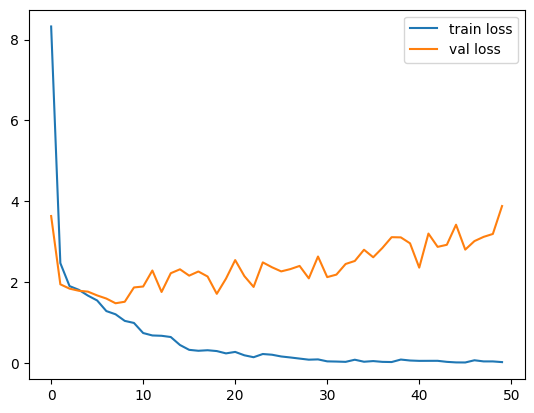

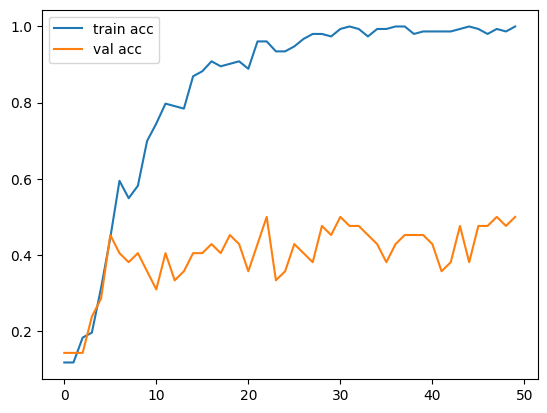

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

Classifier.save('model_Classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y_pred = Classifier.predict(test_set)

2/2 [==============================] - 2s 356ms/step


In [ ]:
y_pred

array([[2.04060125e-05, 6.83122341e-13, 5.16148081e-15, 9.99919593e-01,
        1.61433145e-05, 1.56062628e-11, 4.38351090e-05],
       [2.24719887e-08, 1.95046887e-03, 1.21187069e-08, 1.77922440e-04,
        1.09979123e-06, 5.78499027e-03, 9.92085516e-01],
       [3.53130108e-10, 1.11074175e-03, 1.48201085e-09, 3.48739297e-04,
        1.98376824e-07, 1.60409661e-03, 9.96936202e-01],
       [2.04096362e-09, 4.49665283e-09, 4.55265652e-11, 1.42701247e-04,
        5.78689060e-06, 9.99851227e-01, 2.20457821e-07],
       [1.75871447e-01, 1.02448906e-03, 5.71723759e-01, 4.75180894e-03,
        2.43708789e-02, 2.36415002e-03, 2.19893411e-01],
       [8.80155948e-10, 1.53488102e-08, 9.80415402e-11, 9.07140132e-03,
        2.97661613e-12, 3.40668112e-01, 6.50260568e-01],
       [1.31678089e-12, 2.83129921e-05, 4.08980965e-12, 1.28087049e-05,
        1.61032517e-16, 6.70815155e-07, 9.99958098e-01],
       [1.48784184e-05, 3.95896393e-07, 1.86298188e-14, 1.73263052e-05,
        9.99966443e-01, 7

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([3, 6, 6, 5, 2, 6, 6, 4, 6, 4, 4, 6, 6, 2, 6, 4, 2, 6, 2, 3, 2, 3,
       3, 4, 3, 6, 3, 1, 1, 6, 1, 3, 4, 6, 3, 0, 1, 6, 3, 1, 3, 6])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model_Classifier.h5')

In [ ]:
img=image.load_img('../input/indian-currency-notes-classifier/Test/2Hundrednote/2.jpg',target_size=(224,224))

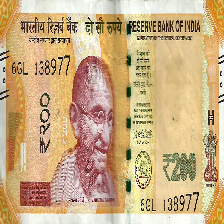

In [ ]:
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

In [ ]:
result = Classifier.predict(test_image)
result

1/1 [==============================] - 0s 45ms/step


array([[0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(test_image), axis=1)

1/1 [==============================] - 0s 42ms/step


In [ ]:
a==5

array([False])

In [ ]:
a==0

array([False])